## Imports

In [1]:
import random
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

In [3]:
cwd = Path().resolve()
base_path = cwd.parent

## Read data

In [4]:
train_val = pd.read_csv(base_path / "data" / "data_train.csv")
test = pd.read_csv(base_path / "data" / "data_test.csv")

## Data exploration

In [5]:
print("Are all product_id unique?", train_val.product_id.size == train_val.product_id.nunique())

Are all product_id unique? True


In [6]:
print("Number of categories train:", train_val.category_id.nunique())

Number of categories train: 101


In [7]:
print("Number of categories test:", train_val.category_id.nunique())

Number of categories test: 101


In [8]:
print("Same categories between train and test?", set(train_val.category_id.unique()) == set(test.category_id.unique()))

Same categories between train and test? True


In [9]:
train_val.category_id.value_counts().sort_values()

14763      657
7511       666
15975      709
2892       734
242        793
         ...  
5661      5441
5662      5677
3056      6862
9821      7125
9820     10009
Name: category_id, Length: 101, dtype: int64

Some categories appear 10k times while other appear 6xx times.

In [10]:
col_names = [f"f{_id}" for _id in range(128)]

for df in [train_val, test]:
    print("mean", "{:.2e}".format(df[col_names].stack().mean()), 
          "median", "{:.2e}".format(df[col_names].stack().median()), 
          "max", "{:.2e}".format(df[col_names].stack().max()), 
          "min", "{:.2e}".format(df[col_names].stack().min()), 
          "q95", "{:.2e}".format(df[col_names].stack().quantile(0.95)), 
          "q99", "{:.2e}".format(df[col_names].stack().quantile(0.99)), 
          "q05", "{:.2e}".format(df[col_names].stack().quantile(0.05)), 
          "q01", "{:.2e}".format(df[col_names].stack().quantile(0.01)))
    

    print(np.linalg.norm(df[col_names].values, axis=1).mean(), np.linalg.norm(df[col_names].values, axis=1).std())

    print("f100",
          "mean", "{:.2e}".format(df["f100"].mean()), 
          "median", "{:.2e}".format(df["f100"].median()), 
          "max", "{:.2e}".format(df["f100"].max()), 
          "min", "{:.2e}".format(df["f100"].min()), 
          "q95", "{:.2e}".format(df["f100"].quantile(0.95)), 
          "q99", "{:.2e}".format(df["f100"].quantile(0.99)), 
          "q05", "{:.2e}".format(df["f100"].quantile(0.05)), 
          "q01", "{:.2e}".format(df["f100"].quantile(0.01)))

mean 7.81e-01 median 1.42e-05 max 1.02e+02 min -3.41e-01 q95 3.79e-02 q99 1.47e-01 q05 -3.54e-02 q01 -7.41e-02
100.00042050214682 0.1295657345705675
f100 mean 1.00e+02 median 1.00e+02 max 1.02e+02 min 9.85e+01 q95 1.00e+02 q99 1.00e+02 q05 9.98e+01 q01 9.97e+01
mean 7.81e-01 median -3.11e-05 max 1.01e+02 min -3.43e-01 q95 3.78e-02 q99 1.41e-01 q05 -3.56e-02 q01 -7.46e-02
100.00009653157524 0.13358378026429446
f100 mean 1.00e+02 median 1.00e+02 max 1.01e+02 min 9.93e+01 q95 1.00e+02 q99 1.00e+02 q05 9.98e+01 q01 9.96e+01


#### Most features values are close to 0.

#### Feature f100 is an odd one out, has values close to 100.

#### We can either normalize this feature or use a training algorithm that is insensitive to feature scale.

#### We can assume that the features f0 to f127 are components of image or text embeddings.

### TSNE visualization

In [11]:
col_names = [f"f{i}" for i in range(128)]

train_small = train_val.groupby("category_id").apply(lambda x: x.sample(n=min(200, x.product_id.count()))).reset_index(drop = True)

train_small["f100"] = train_small["f100"] - 100

In [12]:
categories = [9560, 10149, 15975, 6933, 3076, 5247, 15285, 5247, 5661, 1890, 2919]
train_subset = train_small[train_small.category_id.isin(categories)]

In [13]:
tsne = TSNE(n_components=2, verbose=1, random_state=123, init="pca", learning_rate="auto")

In [14]:
proj_2d = tsne.fit_transform(train_subset[col_names]) 

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 1.015s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.088995


/home/jenazzad/anaconda3/envs/product_classification/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.798195
[t-SNE] KL divergence after 1000 iterations: 1.089904


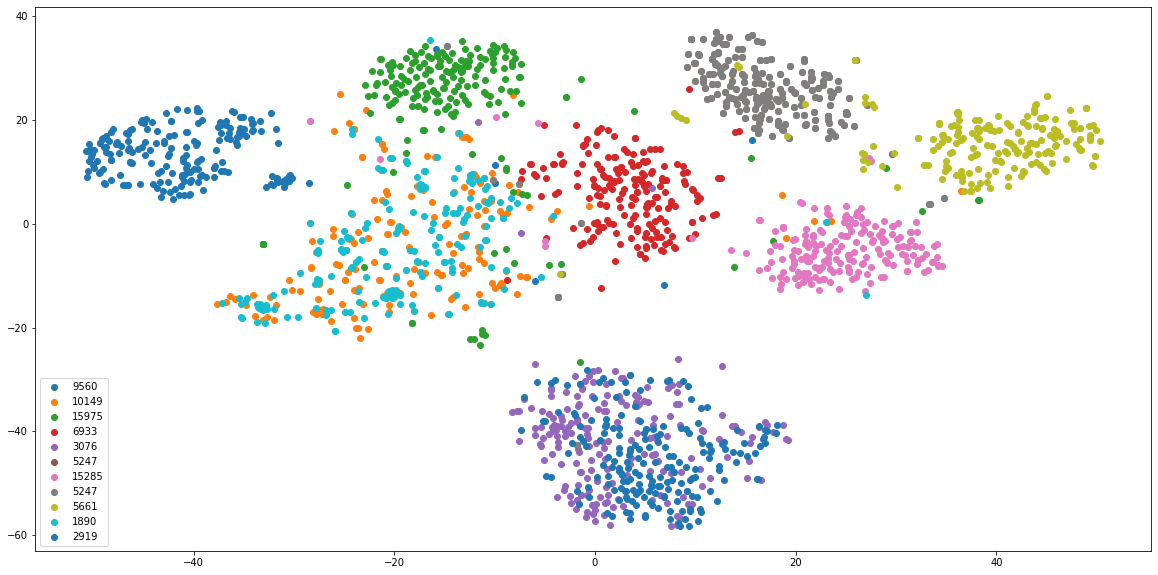

In [15]:
fig = plt.figure(figsize=(20, 10))
for category_id in categories:
    plt.scatter(proj_2d[train_subset.category_id == category_id, 0], proj_2d[train_subset.category_id == category_id, 1], label=category_id)
plt.legend()
plt.show()

#### Some categories are clearly different from others, while some are very similar to each other in the 2D projection space of TSNE.